<a href="https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL-Chapters/blob/main/Beginner_Pouria_TrainingStrategyandComponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Introduction

In [2]:
# Installing required libraries.
%pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

In [3]:
# Importing the required python types for type hinting
# Turning off the notebook warnings

from typing import List, Tuple, Dict, Union, Callable, Iterable
import warnings
warnings.filterwarnings("ignore") 

In [4]:
# Set random seeds for deterministic programming

import torch
import numpy as np
import monai

random_seed = 1000
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
monai.utils.misc.set_determinism(seed=random_seed)

In [5]:
# Selecting the processor device. Make sure your colab runtype is set to GPU.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Downloading the original data from a shortened version of the following link:
# https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/
# f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded.

import os

if not os.path.isdir('chest_xray'):
  !wget -O 'chest_xray.zip' https://bit.ly/3gm0b73
  !unzip -q chest_xray.zip
  os.remove('chest_xray.zip')

In [7]:
# Collecting all image paths, along with their associated labels and sets

def Collect_imageinfo_list(images_dirpath: str) -> List:
  """
  Return a list of information tuples for all images, where each information 
  tuple includes the associated path, label, and set for each image.
  Parameters:
    - images_dirpath (str): Path to the directory including all images.
    - imageinfo_list (List): a list of (file_path, file_label, file_set) 
    for each image file.
  """
  imageinfo_list = list()
  for root, dirs, files in os.walk(images_dirpath):
    for file in files:
        if file.lower().endswith('.jpeg') or file.lower().endswith('.jpg'):
          file_path = os.path.join(root, file)
          dir_path = os.path.dirname(file_path)
          file_label = dir_path.split('/')[-1]
          file_set = os.path.dirname(dir_path).split('/')[-1]
          imageinfo_list.append((file_path, file_label, file_set))
  return imageinfo_list

imageinfo_list = Collect_imageinfo_list('chest_xray')

train_imageinfo_list = [imageinfo for imageinfo in imageinfo_list 
                        if imageinfo[2]=='train']
train_pneumonia_count = len([imageinfo for imageinfo in train_imageinfo_list 
                             if imageinfo[1]=='PNEUMONIA'])
train_normal_count = len([imageinfo for imageinfo in train_imageinfo_list 
                          if imageinfo[1]=='NORMAL'])
test_imageinfo_list = [imageinfo for imageinfo in imageinfo_list 
                       if imageinfo[2]=='test']
test_pneumonia_count = len([imageinfo for imageinfo in test_imageinfo_list 
                            if imageinfo[1]=='PNEUMONIA'])
test_normal_count = len([imageinfo for imageinfo in test_imageinfo_list 
                         if imageinfo[1]=='NORMAL'])

print(f'Number of images in the training set: {len(train_imageinfo_list)} --> \
Pneumonia: {train_pneumonia_count} - Nomral: {train_normal_count}')
print(f'Number of images in the test set: {len(test_imageinfo_list)} --> \
Pneumonia: {test_pneumonia_count} - Nomral: {test_normal_count}')

Number of images in the training set: 5232 --> Pneumonia: 3883 - Nomral: 1349
Number of images in the test set: 624 --> Pneumonia: 390 - Nomral: 234


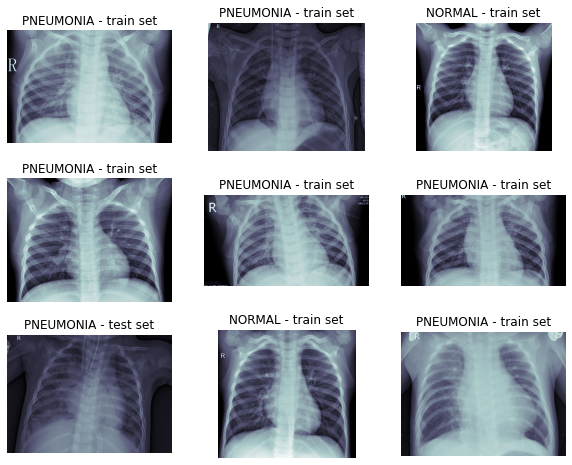

In [8]:
# Plotting sample images from the original data
import random
import matplotlib.pyplot as plt
from skimage.io import imread

def Plot_sample_images():
  """
  Plot 9 sample images from the imaging dataset, while printing their 
  associated labels and sets.
  """
  fig, axes = plt.subplots(3, 3, figsize=(10, 8))
  random_imagesinfo_items = random.choices(imageinfo_list, k=9)
  for i, imageinfo in enumerate(random_imagesinfo_items):
    image = imread(imageinfo[0])
    axes[i//3, i%3].imshow(image, cmap='bone')
    axes[i//3, i%3].axis('off')
    axes[i//3, i%3].set_title(f'{imageinfo[1]} - {imageinfo[2]} set')
  plt.show()

Plot_sample_images()

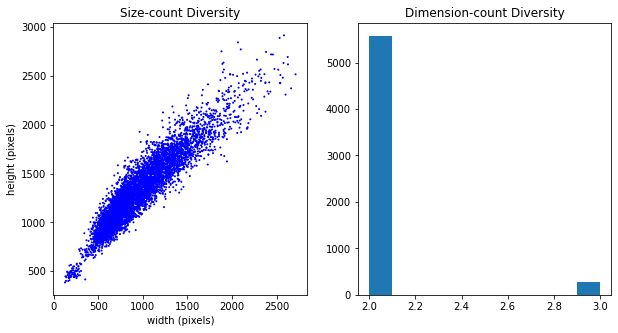

In [9]:
# Investigating the size of the images we have

def Investigate_image_arrays():
  """
  Plot the size-count and dimension-count diversity plots for image arrays.
  """
  image_arrayshape_list = [imread(imageinfo[0]).shape 
                           for imageinfo in imageinfo_list]
  image_size_list = [(shape[0], shape[1]) for shape in image_arrayshape_list]
  image_dimcount_list = [len(shape) for shape in image_arrayshape_list]
  image_size_set = set(image_size_list)
  unique_rows = [size[0] for size in image_size_set],
  unique_columns = [size[1] for size in image_size_set],
  unique_size_counts = [image_size_list.count(size) for size in image_size_set]
  # Plotting:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].scatter(x=unique_rows, y=unique_columns, 
                  s=unique_size_counts, c='blue')
  axes[0].set_title('Size-count Diversity')
  axes[0].set_xlabel('width (pixels)')
  axes[0].set_ylabel('height (pixels)')
  axes[1].hist(image_dimcount_list);
  axes[1].set_title('Dimension-count Diversity');

Investigate_image_arrays()

In [9]:
# Building datasets and dataloaders using MONAI

from monai.transforms import (LoadImageD, EnsureChannelFirstD, ResizeD, Compose,
                              NormalizeIntensityD, RandRotateD, RandZoomD,
                              AddChannelD, LambdaD, ToTensorD, RepeatChannelD)
from monai.data import Dataset, DataLoader
from monai.utils.misc import first

def Collater(data: List) -> Dict:
  """
  A collater function for MONAI dictionary-type datasets.
  We use this collater as MONAI default collate function may result in some
  weird errors occasionally. This may have nee corrected at the time you read
  this notebook, so feel free to import mona.data.list_data_collate and pass it
  to the Build_dataloaders function instead of the Collater function.
  Parameters:
    - data (List): a list of input data to be batched from the dataset.
    - batched_data (Dict): a dictionary of batched input data.
  """
  batch_images = [s['image'] for s in data]
  batch_labels = [s['label'] for s in data]
  images = torch.stack(batch_images, axis=0)
  labels = torch.stack(batch_labels, axis=0)
  labels = labels.to(torch.int64)
  labels = labels.squeeze(-1)
  batched_data = {'image': images, 'label': labels}
  return batched_data

def Build_dataloaders(train_imageinfo_list: List = train_imageinfo_list, 
                      test_imageinfo_list: List = test_imageinfo_list, 
                      Collater: Callable = Collater,
                      fct_to_train: float = 1.0,
                      fct_to_valid: float = 0.5) -> DataLoader:
  """
  Build and return train and test dataloaders.
  Parameters:
    - train_imageinfo_list (list): a list of (file_path, file_label, file_set) 
    for each image file in the training set.
    - test_imageinfo_list (list): a list of (file_path, file_label, file_set) 
    for each image file in the test set.
    - Collator (Callable): a collator function for building the dataloaders.
    - fct_to_train (float): fraction of training data to make available for 
    building the training data loader.
    - fct_to_valid (float): fraction of the test data to use as the validation
    set (and not the test set).
    - train_loader (DataLoader): dataloader for the training set.
    - test_loader (DataLoader): dataloader for the test set.
  """
  label_dict = {'PNEUMONIA':1, 'NORMAL':0}
  train_data_list = [{'image': imageinfo[0], 'label':label_dict[imageinfo[1]]} 
                     for imageinfo in train_imageinfo_list]
  test_data_list = [{'image': imageinfo[0], 'label':label_dict[imageinfo[1]]} 
                    for imageinfo in test_imageinfo_list]
  
  # Shuffling the data before fractioning it
  # Note: We assume that each datapoint in the test_data_list belongs to 
  # a seprate patient.
  random.shuffle(train_data_list)
  random.shuffle(test_data_list)
  
  # Using fractions of data
  P_train_list = [x for x in train_data_list if x['label']==1]
  N_train_list = [x for x in train_data_list if x['label']==0]
  P_test_list = [x for x in test_data_list if x['label']==1]
  N_test_list = [x for x in test_data_list if x['label']==0]
  touse_train_data = P_train_list[:int(len(P_train_list)*fct_to_train)] + \
  N_train_list[:int(len(N_train_list)*fct_to_train)]
  touse_valid_data = P_test_list[:int(len(P_test_list)*fct_to_valid)] + \
  N_test_list[:int(len(N_test_list)*fct_to_valid)]
  touse_test_data = [x for x in test_data_list if x not in touse_valid_data]

  # Building MONAI transforms
  train_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim==3 else x),
          AddChannelD(keys="image"),
          ResizeD(keys="image", spatial_size=(512, 512)),
          NormalizeIntensityD(keys="image"),
          RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
          RandZoomD(keys="image", mode="bilinear"),
          ToTensorD(keys=["image", "label"]),
          RepeatChannelD(keys="image", repeats=3)
          ])
  test_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim==3 else x),
          AddChannelD(keys="image"),
          ResizeD(keys="image", spatial_size=(512, 512)),
          NormalizeIntensityD(keys="image"),
          ToTensorD(keys=["image", "label"]),
          RepeatChannelD(keys="image", repeats=3)
          ])
  
  # Building MONAI datasets
  train_dataset = Dataset(touse_train_data, transform=train_transforms)
  valid_dataset = Dataset(touse_valid_data, transform=test_transforms)
  test_dataset = Dataset(touse_test_data, transform=test_transforms)
  
  # Building MONAI dataloaders
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, 
                            num_workers=2, collate_fn=Collater)
  valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, 
                            num_workers=2, collate_fn=Collater)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, 
                           num_workers=2, collate_fn=Collater)
  return train_loader, valid_loader, test_loader

# Testing the shape and dtype for a sample batche from the training dataloader:

train_loader, valid_loader, test_loader = Build_dataloaders()
sample_batch = first(train_loader)
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['label'] shape: {sample_batch['label'].shape}")
print(f"batch['label'] dtype: {sample_batch['label'].dtype}")

batch['image'] shape: torch.Size([8, 3, 512, 512])
batch['image'] dtype: torch.float32
batch['label'] shape: torch.Size([8])
batch['label'] dtype: torch.int64


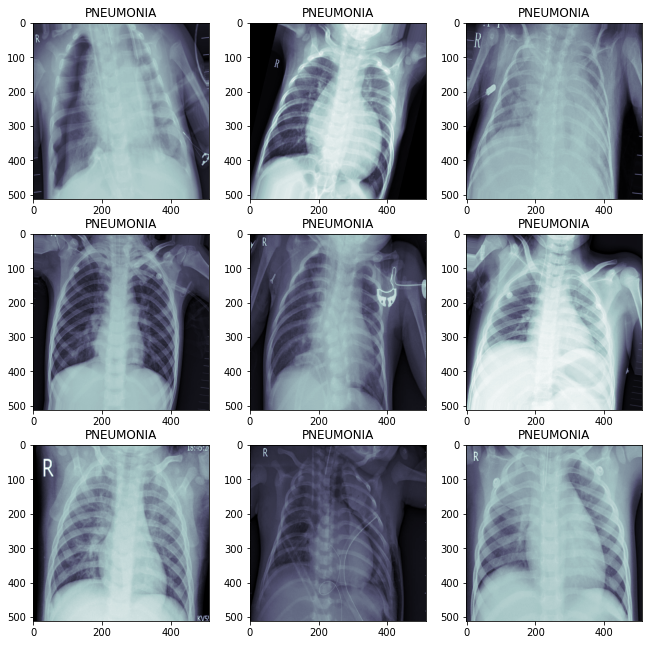

In [11]:
# Plotting sample images from the dataloaders.

def Plot_sample_dataloader_images(dataloader):
  """
  Plot 9 sample images from either the training or test dataloaders.
  """
  label_tensor_dict = {1:'PNEUMONIA', 0:'NORMAL'}
  dataiter = iter(dataloader)
  image_tensor_list = list()
  label_list = list()
  fig, axes = plt.subplots(3, 3, figsize=(11, 11))
  for i in range(9):
    data = dataiter.next()
    image_batch, label_batch = data['image'], data['label']
    axes[i//3, i%3].imshow(image_batch[0][0], cmap='bone')
    axes[i//3, i%3].set_title(label_tensor_dict[int(label_batch[0])])

Plot_sample_dataloader_images(train_loader)

## Part 2: Anatomy of a deep learning model


In [10]:
# Building a resnet model

import torchvision.models as models
import torch.nn as nn
import shutil

def Build_model(arch: str = 'vgg16', pretrained: bool = True)-> Callable:
  """
  Build a resnet model using Pytorch.
  Parameters:
    - arch (str): baseline architecture of the model that could be called using
    torchvision.models.arch command.
    - pretrained (bool): whether or not to use pretrained weights.
    - model (Callable): built pytroch module.
  """
  # Loading a model with the user-specified architecture from torch
  if 'vgg' not in arch and 'resnet' not in arch:
    raise ValueError ('Only resnet or vgg models can be loaded!')
  else:
    try:
      model = eval(f'models.{arch}(pretrained={pretrained})')
    except:
      raise ValueError ('The name of the architecture is not valid!')

  # Replacing the final fully conntected layer of the model
  # Please note that we have two calsses, and therefore, the final FC layer 
  # will have two final nodes
  # The VGG network has not FC layer, so we directly change its final layer
  if 'vgg' in arch:
    model.classifier._modules['6'] = nn.Linear(4096, 2)
  else: 
    num_in_features = model.fc.in_features
    model.fc = nn.Linear(num_in_features, 2)

  # Initializing the weights of the model if not pretrained
  if not pretrained:
    def Weights_init(m: Callable):
      """
      Initialize the weights of a given torch model.
      Parameters:
        m (Callable): any pytorch model.
      """
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)
      if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)
    model = model.apply(Weights_init)

  return model

In [11]:
# A function to evaluate a model's performance on the test_loader

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

def Evaluate_model(model: Callable, 
                   test_loader: Iterable = test_loader,
                   plot_cm: bool = True) -> float: 
  """
  Evaluate a given model's performance on the test set.
  Parameters:
    model (Callable): the pytorch model to be evaluated.
    test_loader (Iterable): test dataloader to be used as the test data.
    plot_cm (bool): whether or not to plot a confusion matrix.
    accuracy (float): accuracy of the model.
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  labels_list = list()
  preds_list = list()
  for batch in tqdm(test_loader):
    inputs, labels = batch['image'].to(device), batch['label'].to(device)
    outputs = model(inputs)
    preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    labels_list.append(labels)
    preds_list.append(preds) 
  all_labels = torch.cat(labels_list).cpu()
  all_preds = torch.cat(preds_list).cpu()
  accuracy = (all_preds == all_labels).sum().item()/len(all_labels)
  
  if plot_cm:
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix - accuracy: {accuracy:.2f}')
    ax.xaxis.set_ticklabels(['Pneumonia', 'Normal']);
    ax.yaxis.set_ticklabels(['Pneumonia', 'Normal']);
  
  return accuracy

In [14]:
# Plotting the structure for a Vgg11 model

from torchsummary import summary
non_trained_resnet18 = Build_model(arch='resnet18', pretrained=False).to(device)
summary(non_trained_resnet18, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

  0%|          | 0/39 [00:00<?, ?it/s]

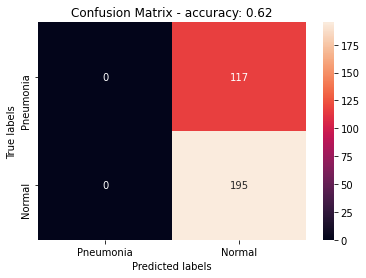

In [70]:
# Evaluating the performance of a non-trained model

_ = Evaluate_model(non_trained_resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/39 [00:00<?, ?it/s]

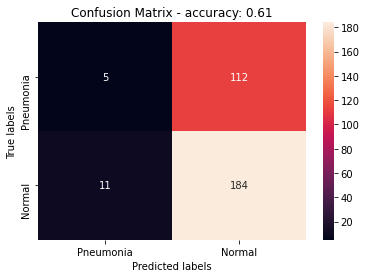

In [24]:
# Evaluating the performance of an ImageNet-pretrained model

Imagenet_pretrained_resnet18 = Build_model(arch='resnet18', pretrained=True)
_ = Evaluate_model(Imagenet_pretrained_resnet18)

## Part 3: Training a deep learning model

In [36]:
def Train_classifier(model: torch.nn.Module,
                     model_name: str, 
                     train_loader: Iterable, 
                     valid_loader: Iterable, 
                     criterion: Callable, 
                     optimizer: torch.optim, 
                     num_epochs: int,
                     plot_curves: bool):
  """
  Train a classifier model using pytorch and the given parameters.
  Parameters:
    model (Callable): any pytorch module,
    model_name (str): name of the model to be saved.
    train_loader (Iterable): dataloader for training data,
    valid_loader (Iterable): dataloader for validation data,
    criterion (Callable): any loss function, 
    optimizer (torch.optim): a pytorch optimizer,
    num_epochs (int): number of epochs to train the model,
    plot_charts (bool): whether or not to plot the training and validation loss
    and accuracy curves.
  """

  # Sending the model to device (preferably GPU)
  model.to(device)

  # Releaseing the GPU memory
  with torch.no_grad():
    torch.cuda.empty_cache()

  # Building a saving directory for models
  model_save_dir = os.path.join('Best_Models', model_name)
  if os.path.exists(model_save_dir):
    shutil.rmtree(model_save_dir)
  os.makedirs(model_save_dir, exist_ok=True)

  # lists to log the epoch values
  epoch_train_loss_list = list()
  epoch_train_accuracy_list = list()
  epoch_valid_loss_list = list()
  epoch_valid_accuracy_list = list()

  # Starting the training loop
  for epoch in range(1, num_epochs+1):
    print("-" * 20, f'\nStarting epoch: {epoch}/{num_epochs}')
    
    ## training
    model.train()
    steps_train_loss = 0.0
    steps_correct_predictions = 0

    for batch in tqdm(train_loader, unit="batch"):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)

      ### Zero the parameter gradients
      optimizer.zero_grad()

      ### Forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      ### Accumulating the loss and number of correct predictions in step
      steps_train_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      steps_correct_predictions += (predicted == labels).sum().item()

    ## Measuring the epoch training loss and accuracy
    epoch_train_loss = steps_train_loss/ len(train_loader)
    epoch_train_loss_list.append(epoch_train_loss)
    epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
    epoch_train_accuracy_list.append(epoch_train_accuracy)

    ## validation
    model.eval()
    steps_valid_loss = 0.0
    steps_correct_predictions = 0

    for batch in tqdm(valid_loader, unit="batch"):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      ### Accumulating the loss and number of correct predictions in step
      steps_valid_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      steps_correct_predictions += (predicted == labels).sum().item()

    ## Measuring the epoch validation loss and accuracy
    epoch_valid_loss = steps_valid_loss/ len(valid_loader)
    epoch_valid_loss_list.append(epoch_valid_loss)
    epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
    epoch_valid_accuracy_list.append(epoch_valid_accuracy)
    
    ## Printing the logs
    print(f'train loss: {epoch_train_loss:.2f} | \
    train accuracy: {epoch_train_accuracy:.2f}')
    print(f'valid loss: {epoch_valid_loss:.2f} | \
    valid accuracy: {epoch_valid_accuracy:.2f}')

    ## Saving the best model
    if epoch==1:
      best_valid_loss = epoch_valid_loss
      weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
      torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
    elif epoch_valid_loss < best_valid_loss:
      weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
      torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
      best_valid_loss = epoch_valid_loss

  # Printing the best model
  print(f'\nTrainng was over. The best model was: {weight_name}') 

  # Plotting the loss and accuracy curves
  if plot_curves:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(epoch_train_loss_list, color='blue', label='training')
    axes[0].plot(epoch_valid_loss_list, color='orange', label='validation')
    axes[0].set_xticks(range(len(epoch_train_loss_list)))
    axes[0].set_title('Loss curves')
    axes[0].legend()
    axes[1].plot(epoch_train_accuracy_list, color='blue', label='training')
    axes[1].plot(epoch_valid_accuracy_list, color='orange', label='validation')
    axes[1].set_xticks(range(len(epoch_train_accuracy_list)))
    axes[1].set_title('Accuracy curves')
    axes[1].legend();

  # Loading the best weights and returning the model
  model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
  return model

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.53 |     train accuracy: 0.74
valid loss: 0.56 |     valid accuracy: 0.63
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.32 |     train accuracy: 0.85
valid loss: 0.56 |     valid accuracy: 0.75
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.22 |     train accuracy: 0.92
valid loss: 0.43 |     valid accuracy: 0.82
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.18 |     train accuracy: 0.93
valid loss: 0.30 |     valid accuracy: 0.88
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.16 |     train accuracy: 0.94
valid loss: 0.51 |     valid accuracy: 0.84
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.14 |     train accuracy: 0.94
valid loss: 0.33 |     valid accuracy: 0.86
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.13 |     train accuracy: 0.95
valid loss: 0.88 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.12 |     train accuracy: 0.95
valid loss: 1.08 |     valid accuracy: 0.70
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.12 |     train accuracy: 0.96
valid loss: 0.38 |     valid accuracy: 0.87
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.11 |     train accuracy: 0.96
valid loss: 0.67 |     valid accuracy: 0.79

Trainng was over. The best model was: resnet18_model_1_Epoch4_ACC=0.8814102564102564.pth


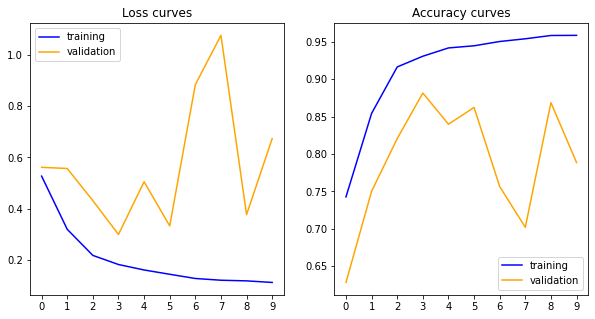

In [26]:
# Doing a base-line training with a non-trained and not-pretrained model

resnet18_model_1 = Build_model(arch='resnet18', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model_1.parameters(), lr=learning_rate)
num_epochs = 10
train_loader, valid_loader, test_loader = Build_dataloaders()
resnet18_model_1 = Train_classifier(model=resnet18_model_1,
                                    model_name='resnet18_model_1', 
                                    train_loader=train_loader, 
                                    valid_loader=valid_loader, 
                                    criterion=criterion, 
                                    optimizer=optimizer, 
                                    num_epochs=num_epochs, 
                                    plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

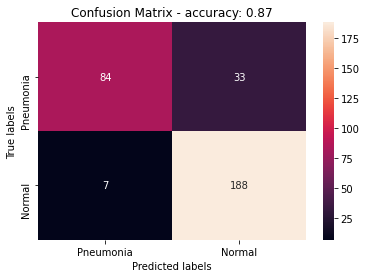

In [27]:
# Evaluating the performance of the trained model

_ = Evaluate_model(resnet18_model_1)

## Part 4: The concept of fit

### Under-fitting

In [28]:
# Under-fitting due to not enough training

resnet18_model_2 = Build_model(arch='resnet18', pretrained=False)
optimizer = torch.optim.SGD(resnet18_model_2.parameters(), lr=learning_rate)
num_epochs = 1
train_loader, valid_loader, test_loader = Build_dataloaders()
resnet18_model_2 = Train_classifier(model=resnet18_model_2,
                                    model_name='resnet18_model_2', 
                                    train_loader=train_loader, 
                                    valid_loader=valid_loader, 
                                    criterion=criterion, 
                                    optimizer=optimizer, 
                                    num_epochs=num_epochs, 
                                    plot_curves=False)

-------------------- 
Starting epoch: 1/1


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.54 |     train accuracy: 0.74
valid loss: 0.70 |     valid accuracy: 0.62

Trainng was over. The best model was: resnet18_model_2_Epoch1_ACC=0.625.pth


  0%|          | 0/39 [00:00<?, ?it/s]

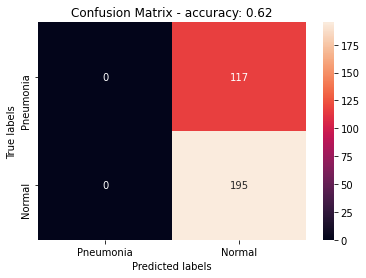

In [29]:
# Evaluating the performance of under-fitting model 1

_ = Evaluate_model(resnet18_model_2)

### Over-fitting

### Regularization

### Transfer learning

## Part 5: Using a trained model for inference

## Part 6: Conclusion and further reading

## Part 5: References